# Explainer Jupyter Notebook. 

In [2]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from math import radians, cos, sin, asin, sqrt
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Motivation

The dataset we'll be exploring is all the 311 service requests from New York City since 2010 to present. 311 service requests are complaints that New Yorkers can file by phone, online or by mobile phone to New York officials, and it can range between anything from noise complaints and street conditions, to more serious issues such as homelessnes and animal abuse. This dataset is interesting to explore since it holds both spatial and temporal information about each complaint, and can thus give us a picture of New Yorkers' habits thoughout the day, month or year and also across different boroughs. Additionally this dataset is up-to-date, and thus also provides data from 2020 where New York was in lockdown, which could be really interesting to explore. 

The idea for the webpage was for users to be able to explore all the patterns in this dataset, and thus use different plots to extract both spatial, temporal and categorical information (information about different categories of complaints) so that the user can get an insight into some of the habits of New Yorkers. The website will thus mostly be user driven since there are so many combinations of categories, locations and time intervals that can be explored and compared to each other, that the user would learn a lot more if he explored himself, rather than the author laying everything out on the table.

# Data Preprocessing, Cleaning and Basic stats

### Data preprocessing: reducing the size of the dataset

<br>

The 311 service requests data is a very big dataset, as hundreds of complaints are filed every day. The dataset takes up 13.5 GB of data, which makes it very heavy to work with and it would take a long time to do simple data analysis. It is therefore a crucial first step to reduce the size of the dataset so that it becomes easier to process.

In [ ]:
service_data = pd.read_csv('/Users/christinabartozzi/Documents/DTU/Year1/Semester2/SocialDataAnalysis/311_Service_Requests_from_2010_to_Present.csv')

<br>

To reduce the size of the dataset, we will randomly select 10% of the service requests filed since 2010, and we will use these as representatives of the original data. Another approach to reduce the dataset could have been to just select a particular year and do data analysis for that year. However, we were interested in examining if the complaint types changed over the years, and so we decided that it was important to keep data from all the years since 2010.

In [ ]:
service_data_sampled = service_data.sample(frac=0.1)

<br>

We save this final dataset as a csv file:

In [ ]:
service_data_sampled.to_csv(r'/Users/christinabartozzi/Documents/DTU/Year1/Semester2/SocialDataAnalysis/service_data_final.csv',index=False)

In [ ]:
service_dataset = pd.read_csv('/Users/christinabartozzi/Documents/DTU/Year1/Semester2/SocialDataAnalysis/service_data_final.csv')

<br>

This new dataset uses 1.4 GB, so it's still very large. We thus decided that it would be too heavy to have interactive visualisations, for example maps, on the website that contain all this data. However, for data analysis in this explainer notebook, using as much data as possible gives the most representative results. We will thus keep the 1.4 GB dataset for use in this notebook, but will use a much smaller dataset for the interactive visualisations on the website.

We create the website dataset by further downsampling the dataset by randomly selecting 20% of the datapoints from the already reduced dataset:

In [ ]:
website_dataset = service_dataset.sample(frac=0.2)

<br>

We also save the website dataset as a csv file:

In [ ]:
website_dataset.to_csv(r'/Users/christinabartozzi/Documents/DTU/Year1/Semester2/SocialDataAnalysis/service_data_1.csv',index=False)

In [ ]:
website_dataset = pd.read_csv('/Users/christinabartozzi/Documents/DTU/Year1/Semester2/SocialDataAnalysis/service_data_1.csv')

<br>

The website dataset uses 277.6 MB, so is still quite large, but is much lighter than using the 1.4 GB dataset, which would most certainly give responsiveness issues on our website. 

Note: We will be doing exactly the same data cleaning and preprocessing on the website dataset, as we will do on the main dataset, but we will not show them being applied to the website dataset, as we are focusing on the main dataset in this explainer notebook.

<br>

### Data cleaning

We'll start with examining the attributes, the datatypes and the null values of the dataset:

In [4]:
service_dataset.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534287 entries, 0 to 2534286
Data columns (total 41 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Unique Key                      2534287 non-null  int64  
 1   Created Date                    2534287 non-null  object 
 2   Closed Date                     2465891 non-null  object 
 3   Agency                          2534287 non-null  object 
 4   Agency Name                     2534287 non-null  object 
 5   Complaint Type                  2534287 non-null  object 
 6   Descriptor                      2498431 non-null  object 
 7   Location Type                   1921202 non-null  object 
 8   Incident Zip                    2395479 non-null  object 
 9   Incident Address                2099357 non-null  object 
 10  Street Name                     2099210 non-null  object 
 11  Cross Street 1                  1718398 non-null  object 
 12  

#### Convert temporal columns to datetime format


To be able to use the temporal information in the data, we need to convert the 'Created Date', 'Closed Date' and 'Resolution Action Updated Date' attributes to datetime format:

In [5]:
service_dataset['Created Date'] = pd.to_datetime(service_dataset['Created Date'],errors='coerce')
service_dataset['Closed Date'] = pd.to_datetime(service_dataset['Closed Date'],errors='coerce')
service_dataset['Resolution Action Updated Date'] = pd.to_datetime(service_dataset['Resolution Action Updated Date'],errors='coerce')
service_dataset['Due Date'] = pd.to_datetime(service_dataset['Due Date'],errors='coerce')

#### Remove columns that we won't be using


We have 40 attributes in total. We'll now look at if there are any of the attributes that we can drop from the dataset if we don't need them for our data analysis.

We can drop 'Agency' since it stores the same information as 'Agency Name'. <br>

We can also drop 'Cross Street 1', 'Cross Street 2', 'Intersection Street 1', and 'Intersection Street 2' as they store information about surrounding streets, which we don't need. <br>

BBL is a number to identify the location of buildings in NYC. We dont need this since we have the latitude and longitude.<br>

We don't need the 'X Coordinate (State Plane)' or 'Y Coordinate (State Plane)' either, since we will be using the latitude and longitude instead. <br>

We're not interested in the bridge or highway segment where an incident took place either, so we can drop that column too.<br>

The Location attribute just combines the longitude and latitude attributes into one, so we can drop this one as well.<br>

In [6]:
service_dataset.drop('Agency', axis=1, inplace=True)
service_dataset.drop('Cross Street 1', axis=1, inplace=True)
service_dataset.drop('Cross Street 2', axis=1, inplace=True)
service_dataset.drop('Intersection Street 1', axis=1, inplace=True)
service_dataset.drop('Intersection Street 2', axis=1, inplace=True)
service_dataset.drop('BBL', axis=1, inplace=True)
service_dataset.drop('X Coordinate (State Plane)', axis=1, inplace=True)
service_dataset.drop('Y Coordinate (State Plane)', axis=1, inplace=True)
service_dataset.drop('Bridge Highway Segment', axis=1, inplace=True)
service_dataset.drop('Location', axis=1, inplace=True)

<br>

There are another two columns that are redundant, namely 'Road Ramp' and 'Facility Type'. <br>

The 'Road Ramp' attribute specifies whether an incident with value 'Bridge/Highway' in the Location Type column, happened on the bridge or on the road. We can thus drop this attribute, and instead just change the 'Bridge/Highway' values in the Location Type column to either 'Road' or 'Ramp':


In [7]:
service_dataset.loc[service_dataset['Road Ramp'] == 'Road', 'Location Type'] = 'Road'
service_dataset.loc[service_dataset['Road Ramp'] == 'Ramp', 'Location Type'] = 'Ramp'

<br>

The 'Facility Type' column doesn't give us any important information either. It only has the following unique values:

In [8]:
service_dataset['Facility Type'].value_counts()

Precinct           475569
DSNY Garage         81145
School               1633
School District       159
Name: Facility Type, dtype: int64

The only of these that are of interest are the 'School' and 'School District' values - we aren't interested in the 'Precinct' or 'DSNY Garage' values. However, the 'Location Type' column also specifies when an incident happens at a school. So before we drop the 'Facility Type' we can use it to fill in any null values in the 'Location Type' column with 'School' if they have the value 'School' or 'School District' in their 'Facility Type' column:


In [9]:
service_dataset.loc[(service_dataset['Facility Type'] == 'School') & (service_dataset['Location Type'].isnull()), 'Location Type'] = 'School'
service_dataset.loc[(service_dataset['Facility Type'] == 'School District') & (service_dataset['Location Type'].isnull()), 'Location Type'] = 'School'

Now we can drop these two columns as well:

In [10]:
service_dataset.drop('Road Ramp', axis=1, inplace=True)
service_dataset.drop('Facility Type', axis=1, inplace=True)

<br>

#### Handling rows with null values in certain columns


We could see from above that some of the complaints don't have longitude and latitude values specified. Since these values are very important, we will drop the rows where these values are missing from the dataset:

In [11]:
service_dataset = service_dataset[service_dataset['Latitude'].notna()]
service_dataset = service_dataset[service_dataset['Longitude'].notna()]

<br>

We also saw above that not all complaints have a closed date. This is ok if the complaint has not been resolved yet. However, if the Status column indicates that it has already been resolved, then we should set a closed date. We will use the 'Resolution Action Updated Date' (the date that the status of the complaint has been updated) as the closed date as well.

In [12]:
# let's see which values in the 'Status' column are used to specify that a complaint has been terminated
service_dataset['Status'].value_counts()

Closed              2223310
Pending               36323
Open                  27645
In Progress           16725
Assigned              15656
Started                 945
Unspecified               3
Closed - Testing          1
Unassigned                1
Name: Status, dtype: int64

In [13]:
# replace the nan values with the status update date
service_dataset.loc[(service_dataset['Status'] == 'Closed') & (service_dataset['Closed Date'].isnull()), 'Closed Date'] = service_dataset.loc[(service_dataset['Status'] == 'Closed') & (service_dataset['Closed Date'].isnull()), 'Resolution Action Updated Date'].values

Now we have 21 rows where the complaint is closed, but without a specified closed date:

In [14]:
print(len(service_dataset[(service_dataset['Status'] == 'Closed') & (service_dataset['Closed Date'].isnull())])) 

21


We can just drop these rows, as there are only 21. We do this by keeping the rows where 'Closed Date' is not null or the 'Status' is not closed.

In [15]:
print(len(service_dataset))
service_dataset = service_dataset.loc[(service_dataset['Status'] != 'Closed') | (service_dataset['Closed Date'].notnull())]
print(len(service_dataset))

2320609
2320588


The rest of the complaints that don't have a closed date have still not been resolved yet, so it is ok for them to have a null value.

#### Make sure data ranges are ok

We should also make sure that the dates columns are correct by making sure that the year is between 2010 and 2021.

In [16]:
service_dataset = service_dataset.loc[(service_dataset['Created Date'].dt.year > 2009) & (service_dataset['Created Date'].dt.year < 2022)]

# closed date can either be null if it isn't closed yet, or otherwise it has to be in the range 2010 - 2021
service_dataset = service_dataset.loc[service_dataset['Closed Date'].isnull() |((service_dataset['Closed Date'].dt.year > 2009) & (service_dataset['Closed Date'].dt.year < 2022))]

In [17]:
print(len(service_dataset))

2320007


In [18]:
# Resolution Action Updated Date can either be null, or otherwise it has to be in the range 2010 - 2021
service_dataset = service_dataset.loc[service_dataset['Resolution Action Updated Date'].isnull() | ((service_dataset['Resolution Action Updated Date'].dt.year > 2009) & (service_dataset['Resolution Action Updated Date'].dt.year < 2022))]
print(len(service_dataset))
# the due date shouldn't have an upper bound,and it can also be null if the incident doesn't have a due date
service_dataset = service_dataset.loc[(service_dataset['Due Date'].dt.year > 2009) | (service_dataset['Due Date'].isnull())]
print(len(service_dataset))

2320007
2319974


We also want to make sure that the latitudes and longitudes are not out of range.

In [19]:
service_dataset = service_dataset.loc[(service_dataset['Longitude']> -74.5) & (service_dataset['Longitude'] < -73)]
service_dataset = service_dataset.loc[(service_dataset['Latitude']> 40) & (service_dataset['Latitude'] < 41.5)]

In [20]:
print(len(service_dataset))

2319974


Let's also check the values of the Borough column:

In [21]:
service_dataset['Borough'].value_counts()

BROOKLYN         703688
QUEENS           535799
MANHATTAN        453415
BRONX            426916
STATEN ISLAND    117275
Unspecified       82881
Name: Borough, dtype: int64

We can drop the rows where the Borough is unspecified:

In [22]:
service_dataset = service_dataset[service_dataset['Borough'].isin(['BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND'])]

Let's check the values of the Open Data Channel Type column:

In [23]:
service_dataset['Open Data Channel Type'].value_counts()

PHONE      1151211
ONLINE      444734
UNKNOWN     400358
MOBILE      204988
OTHER        35802
Name: Open Data Channel Type, dtype: int64

These values are fine - we don't need to change anything.

Let's check the values of the Status column:

In [24]:
service_dataset['Status'].value_counts()

Closed              2142767
Pending               36301
Open                  25238
In Progress           16722
Assigned              15115
Started                 945
Unspecified               3
Closed - Testing          1
Unassigned                1
Name: Status, dtype: int64

We are only interested in whether a complaint is resolved (closed) or unresolved. So we will convert the values 'Pending', 'Assigned', 'In Progress', 'Open', and 'Unassigned' to 'Unresolved':

In [25]:
service_dataset.loc[(service_dataset['Status'] == 'Pending'), 'Status'] = 'Unresolved'
service_dataset.loc[(service_dataset['Status'] == 'Assigned'), 'Status'] = 'Unresolved'
service_dataset.loc[(service_dataset['Status'] == 'In Progress'), 'Status'] = 'Unresolved'
service_dataset.loc[(service_dataset['Status'] == 'Open'), 'Status'] = 'Unresolved'
service_dataset.loc[(service_dataset['Status'] == 'Unassigned'), 'Status'] = 'Unresolved'

#### Result of data cleaning 

Let's now look at our final dataset after the data cleaning:

In [26]:
service_dataset.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2237093 entries, 0 to 2534286
Data columns (total 29 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   Unique Key                      2237093 non-null  int64         
 1   Created Date                    2237093 non-null  datetime64[ns]
 2   Closed Date                     2175397 non-null  datetime64[ns]
 3   Agency Name                     2237093 non-null  object        
 4   Complaint Type                  2237093 non-null  object        
 5   Descriptor                      2208872 non-null  object        
 6   Location Type                   1736474 non-null  object        
 7   Incident Zip                    2236677 non-null  object        
 8   Incident Address                1963207 non-null  object        
 9   Street Name                     1963196 non-null  object        
 10  Address Type                    1974030 no

A little note on some of the attributes: There are some columns that are not relevant for all complaints but rather provide some extra information that may be helpful for some special types of complaints. These special types of complaints include: complaints filed in a park, complaints aimed towards a taxi and complaints concerning incidents on roads or highways. These attributes are listed below:

Park complaints
* Park Facility Name
* Park Borough

Taxi complaints
* Vehicle Type
* Taxi Company Borough
* Taxi Pick Up Location 

Road complaints
* Bridge Highway Name
* Bridge Highway Direction 


<br>

### Data preprocessing part 2: create a 'Duration' column

Our dataset contains a column 'Created Date' for when the complaint was created, and a column 'Closed Date' for when the complaint was resolved. It would be interesting to analyse the duration of complaint types, and see if some complaints are resolved faster than others. To facilitate this, we can create a new column 'Duration' where the duration has been precalculated, using these two columns.
<br>


In [27]:
# create the duration column
# Note: some of the closed date values are null - where the complaint hasn't been resolved yet
# thus for unresolved complaints, the duration will also be null
service_dataset['Duration'] = service_dataset["Closed Date"] - service_dataset['Created Date']
service_dataset['Duration']

0         56 days 08:12:16
1          0 days 21:27:00
2         29 days 10:18:19
3          0 days 00:07:39
4         24 days 00:29:45
                ...       
2534282    4 days 00:00:00
2534283   15 days 03:00:22
2534284    3 days 23:40:13
2534285   35 days 05:07:25
2534286    2 days 01:53:00
Name: Duration, Length: 2237093, dtype: timedelta64[ns]

<br>

### Basic Stats

To do some exploratory data analysis, we will go through some of the attributes, and try to find any interesting patterns or trends that may be present in the data. Some aspects of the data that would be interesting to examine and the corresponding attributes are listed below:

* Information about the complaint: Complaint Type and Descriptor 
* Spatial data: Borough, Latitude, Longitude and Location Type
* Temporal data: Created Date and Duration
* How complaints are submitted: Open Data Channel Type         



#### Complaint Type attribute

The first attribute we will explore is the complaint type.

In [28]:
service_dataset['Complaint Type'].value_counts().head(20)

Noise - Residential                    229239
HEAT/HOT WATER                         148151
Illegal Parking                        116783
Blocked Driveway                       107493
Street Condition                        97359
Noise - Street/Sidewalk                 70134
Water System                            67816
PLUMBING                                62724
HEATING                                 59257
Street Light Condition                  57305
Noise                                   52480
UNSANITARY CONDITION                    52468
Noise - Commercial                      39962
PAINT/PLASTER                           39039
Sewer                                   37596
General Construction/Plumbing           36935
Dirty Conditions                        36874
Damaged Tree                            35709
GENERAL CONSTRUCTION                    34992
Request Large Bulky Item Collection     32413
Name: Complaint Type, dtype: int64

There are 247 unique complaint types of which residential noise is the most common one. This is expected from New York which is one of the busiest cities in the world. Other common complaints of New Yorkers include parking problems such as illegal parking or blocked driveways and also general maintenance issues in the home such as heating, plumbing and water issues. Also street conditions are reported a lot including street lights that aren't working and noise from the street. Some surprising complaitns that are in the top 20 are damaged trees and the requests for collection of large bulky items. 

<br> 

Let's now look at the 50 complaints that have happen the fewest times:

In [29]:
service_dataset['Complaint Type'].value_counts().tail(50)

Overflowing Recycling Baskets        17
FCST                                 17
Health                               17
Cooling Tower                        17
Peeling Paint                        16
Highway Sign - Missing               16
Bottled Water                        15
X-Ray Machine/Equipment              15
Calorie Labeling                     13
Radioactive Material                 11
Unlicensed Dog                       10
Wood Pile Remaining                  10
Transportation Provider Complaint     8
Registration and Transfers            8
Squeegee                              8
Trans Fat                             7
DOF Property - Reduction Issue        6
Tanning                               6
Foam Ban Enforcement                  6
Single Occupancy Bathroom             5
Green Taxi Report                     5
Special Enforcement                   4
Highway Sign - Dangling               4
FHV Licensee Complaint                4
Parent Leadership                     4


Of these we found it interesting that there are 11 complaints about Radioactive Material and that X-Ray Machine/Equipment has been reported 15 times. Lets look at the descripotr for these complaints:

In [30]:
service_dataset[service_dataset['Complaint Type']=='Radioactive Material'][['Descriptor', 'Created Date','Resolution Description']]

Descriptor        Created Date  \
23882            Contamination Risk 2021-01-03 05:29:21   
180661           Contamination Risk 2010-05-22 19:31:42   
625138              User Unlicensed 2019-03-29 12:39:14   
977767           Contamination Risk 2018-08-08 07:37:55   
1136330          Contamination Risk 2011-07-05 14:50:14   
1602611          Contamination Risk 2019-04-11 02:05:09   
1634951             User Unlicensed 2010-01-24 22:17:20   
1879183  Material Stored Improperly 2010-12-03 11:52:18   
1918831          Contamination Risk 2019-09-09 12:38:48   
2233089          Contamination Risk 2019-12-02 17:54:05   
2439766             User Unlicensed 2019-10-05 18:41:54   

                                    Resolution Description  
23882    The Department of Health and Mental Hygiene ha...  
180661   The Department of Health and Mental Hygiene de...  
625138   The Department of Health and Mental Hygiene ha...  
977767   The Department of Health and Mental Hygiene ha...  
1136330  The Department of Health and Mental Hygiene ha...  
1602611  The Department of Health and Mental Hygiene ha...  
1634951  The Department of Health and Mental Hygiene ha...  
1879183  The Department of Health and Mental Hygiene de...  
1918831  The Department of Health and Mental Hygiene ha...  
2233089  The Department of Health and Mental Hygiene ha...  
2439766  The Department of Health and Mental Hygiene ha...

Many of the radioactive material complaints have been either in 2010 or 2019. Perhaps some of these complaints relate to the same user or event, that is not handling radioactive material correctly.

In [31]:
service_dataset[service_dataset['Complaint Type']=='X-Ray Machine/Equipment'][['Descriptor', 'Created Date','Resolution Description',]]

Descriptor        Created Date  \
363903           Equipment Malfunction 2020-05-02 08:50:32   
491360            Exposure Unnecessary 2020-06-07 22:11:36   
611118           Facility Unregistered 2021-01-19 21:41:36   
837337           Technician Unlicensed 2015-08-17 11:16:41   
1043308           Exposure Unnecessary 2020-05-09 06:21:32   
1198707  Exposure from Nearby Facility 2013-09-25 15:48:50   
1291355          Facility Unregistered 2013-10-03 13:42:48   
1298706          Facility Unregistered 2021-01-23 22:08:26   
1302318  Overexposure During Treatment 2016-02-19 17:36:49   
1415399           Exposure Unnecessary 2020-05-25 12:09:34   
1494527           Exposure Unnecessary 2011-06-14 12:48:25   
1729338           Exposure Unnecessary 2020-05-03 23:11:55   
2062225           Exposure Unnecessary 2020-05-29 12:30:40   
2163304           Exposure Unnecessary 2020-06-06 15:44:58   
2207884          Equipment Malfunction 2017-08-18 12:22:43   

                                    Resolution Description  
363903   The Department of Health and Mental Hygiene ha...  
491360   The Department of Health and Mental Hygiene ha...  
611118   The Department of Health and Mental Hygiene ha...  
837337   The Department of Health and Mental Hygiene ha...  
1043308  The Department of Health and Mental Hygiene ha...  
1198707  The Department of Health and Mental Hygiene ha...  
1291355  The Department of Health and Mental Hygiene ha...  
1298706  The Department of Health and Mental Hygiene ha...  
1302318  The Department of Health and Mental Hygiene ha...  
1415399  The Department of Health and Mental Hygiene ha...  
1494527  The Department of Health and Mental Hygiene ha...  
1729338  The Department of Health and Mental Hygiene ha...  
2062225  The Department of Health and Mental Hygiene ha...  
2163304  The Department of Health and Mental Hygiene ha...  
2207884  The Department of Health and Mental Hygiene ha...

Before 2020, there were only 6 occureces of x-ray complaints. This more than doubled in 2020-2021, where an increase of people somehow feel that they have been unnecessarily exposed to x-ray.

<br>

#### Exploring the spatial patterns in the data

To explore the spatial information in the data, we will be looking at the 'Borough', 'Location Type' and 'Latitude' 'Longitude' attributes.

<br>

##### Borough attribute

There are five boroughs in New York City: Brooklyn, Queens, Manhattan, Bronx and Staten Island. Let's see which borough has made the most complaints:

In [32]:
service_dataset['Borough'].value_counts()

BROOKLYN         703688
QUEENS           535799
MANHATTAN        453415
BRONX            426916
STATEN ISLAND    117275
Name: Borough, dtype: int64

The current population distributions in the boroughs is as follows: 

* BROOKLYN: 2,559,903 (30.7%)
* QUEENS: 2,253,858 (27%)
* MANHATTAN: 1,628,706 (19.5%)
* BRONX: 1,418,207 (17%)
* STATEN ISLAND: 476,143 (5.7%)

Calculating the percentage of complaints for each borough gives us:

* BROOKLYN: 31.5%
* QUEENS: 24%
* MANHATTAN: 20.3%
* BRONX: 19.1%
* STATEN ISLAND: 5.2%

We can see that Queens complains the least compared to their population and Bronx complains the most.

<br>

We also want to explore how complaint types are distributed across the different boroughs of New York. However, there are 247 different complaint types, so we don't want to create a graph for each of them. We thus choose the 40 most frequent complaint types and plot them across the different boroughs in histograms. The complaint counts will be normalised with the population of the borough, to make it easier to compare the frequencies between the boroughs.

In [33]:
# getting top 40 complaint data
top_40_complaints = service_dataset['Complaint Type'].value_counts().head(40).rename_axis('unique_values').to_frame('counts')
top_40_complaints = top_40_complaints.index.tolist()
top_40_complaints_data = service_dataset[service_dataset['Complaint Type'].isin(top_40_complaints)]

# group the data
g = top_40_complaints_data.groupby('Complaint Type')

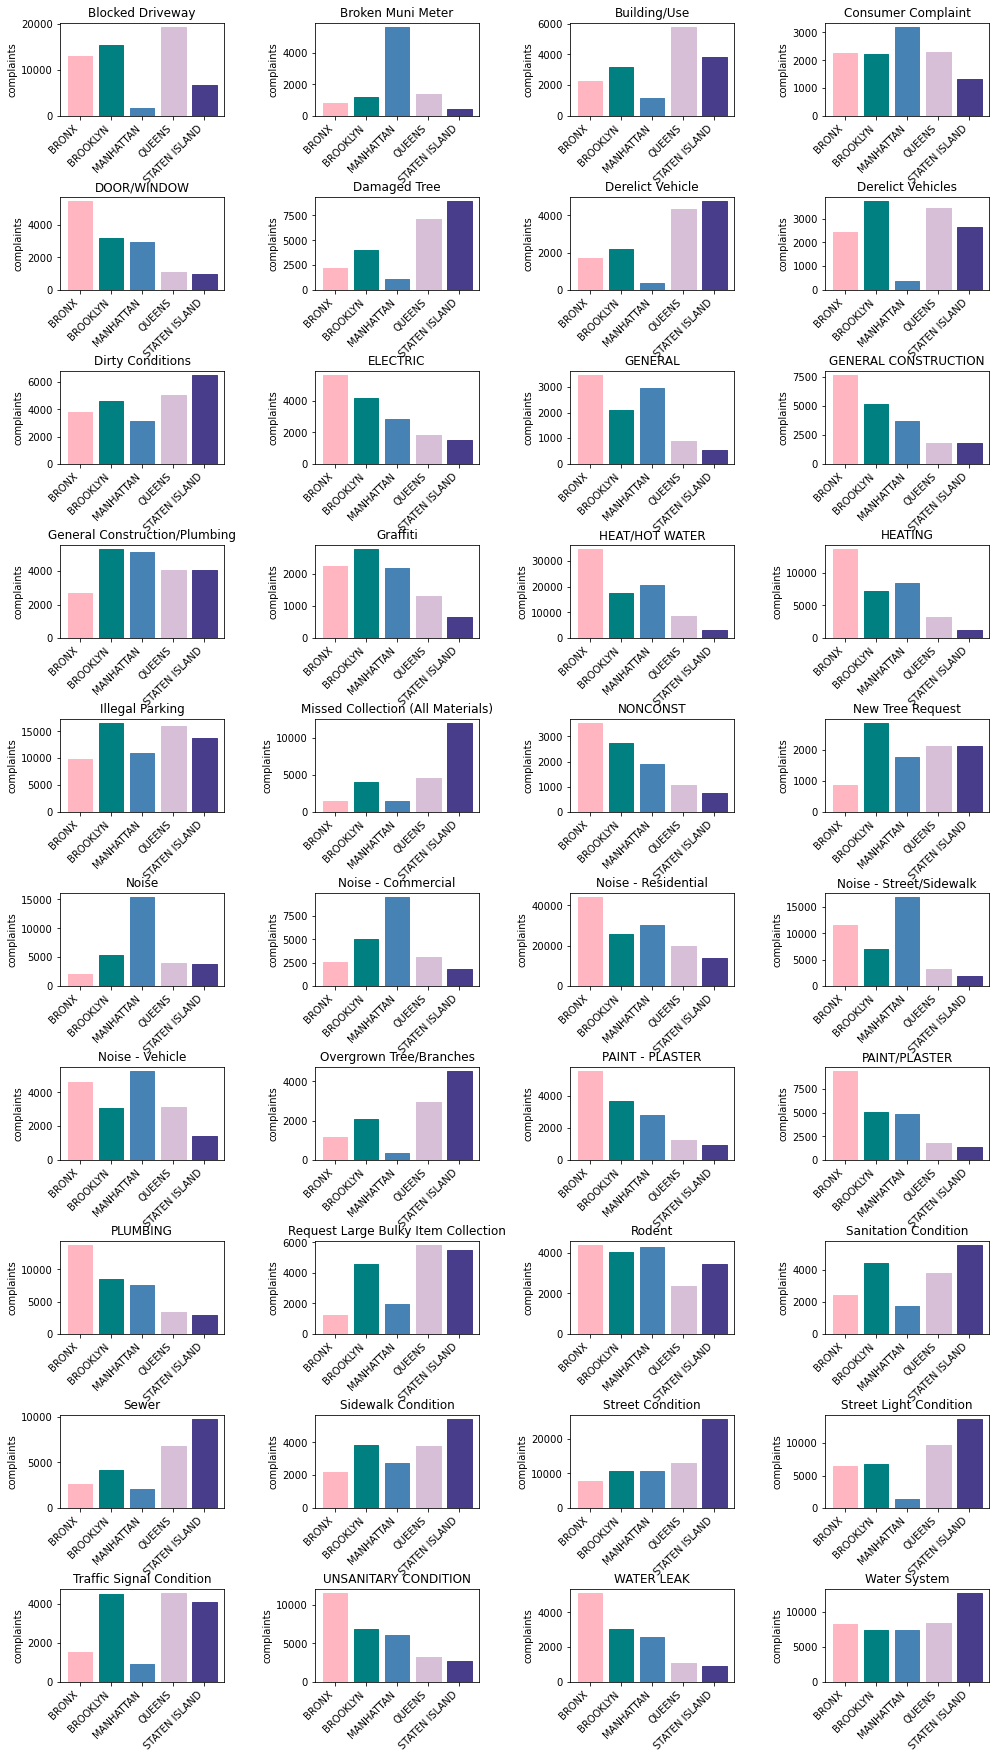

In [34]:
fig, axes = plt.subplots(10, 4, figsize = (15,25))
axes = axes.flatten()

fig.tight_layout(pad=6.0)

# the population of each borough will be used to make the complaint counts more comparable
population = {'BRONX': 1418207 ,'BROOKLYN':2559903,'MANHATTAN':1628706,'QUEENS':2253858,'STATEN ISLAND': 476143}
colours = ['lightpink','teal','steelblue','thistle','darkslateblue']

#fill each subplot with histogram
for i, (cat, group) in enumerate(g): 
    axes[i].set_title(cat)
    axes[i].set_ylabel('complaints')
    labels, counts = np.unique(group['Borough'], return_counts=True)

    # divide by population of the borough
    for l, label in enumerate(labels): 
        pop = population[label]
        counts[l] = (counts[l]/pop)*1000000
        
    barlist= axes[i].bar(labels, counts, align='center')
    
    for j,b in enumerate(barlist):
        barlist[j].set_color(colours[j])

    axes[i].set_xticklabels(labels, rotation=45, ha='right')
    

plt.show()

These plots show us a lot of interestting patterns:

For all of the different types of noise complaints (street, commercial, vehicle) Manhattan has the highest number of relative complaints, except for in the category residential noise - Bronx has many more complaints for this category. Manhattan also takes the lead for complaints towards broken muni meters and consumer complaints, since most shops and restuarants in NYC are located in Manhattan.

Complaints concerning street conditions (sewer, sidewalk condition, street lights, overgrown trees, dirty conditions, missed collection), happen most frequently on Staten Island. 

Bronx exceeds the other boroughs in the number of complaint towards the state of their residences. In the complaint categories water leak, plumbing, paint/plaster, heating, hot water, electric, door/window, and unsanitary condition, Bronx has the highest relative number of complaints.

Queens overtakes the other boroughs in the categories: blocked driveway, traffic signal condition, illegal parking and requesting large bulky item collection. This indicates that their complaints are mostly directed towards parking issues, and the condition of the road (traffic lights) and sidewalk (collection of large items).

Brooklyn has the most complaints in the categories: new tree requests, illegal parking, derelict vehicle, grafiti, and general construction/plumbing. Traffic signal condition complaints are also happening a lot in Brooklyn. These complaints are similar to those made in Queens in that they mostly concern parking problems. However the complaints regarding grafiti also show us that vandalism is common in this borough. General construction and plumbing complaints also indicate that the building in Brooklyn may be older and require some more maintenance. Latsly, the many requests for new trees means that they take good care of their green areas in Brooklyn.


<br>

##### Location type attribute

We will now explore the location types where complaints occur most often. We also want to find the most common complaint type per location type, to discover which problems are most common in which types of locations. 

In [35]:
service_dataset['Location Type'].value_counts().head(20)

RESIDENTIAL BUILDING            565436
Street/Sidewalk                 371343
Residential Building/House      237221
Street                          223569
Sidewalk                        156865
Store/Commercial                 32910
Club/Bar/Restaurant              20442
3+ Family Apt. Building          13302
Restaurant/Bar/Deli/Bakery       10976
1-2 Family Dwelling              10533
Lot                               8561
Park                              7125
Park/Playground                   6810
Mixed Use                         6640
3+ Family Apartment Building      6000
Other (Explain Below)             5066
Comercial                         4940
Commercial Building               4639
Residential                       3042
Street/Curbside                   2901
Name: Location Type, dtype: int64

The most common type of location where complaints happen are in residential buildings. This is expected since any problem that may arise in our homes are most likely being submitted since we in general want our homes to be in order. 
In second place is the street and sidewalk and third comes stores and other commercial locations.

<br>

Below we plot, for the most common location types, the number of different complaint types (just the 20 most common) that happen in such locations:

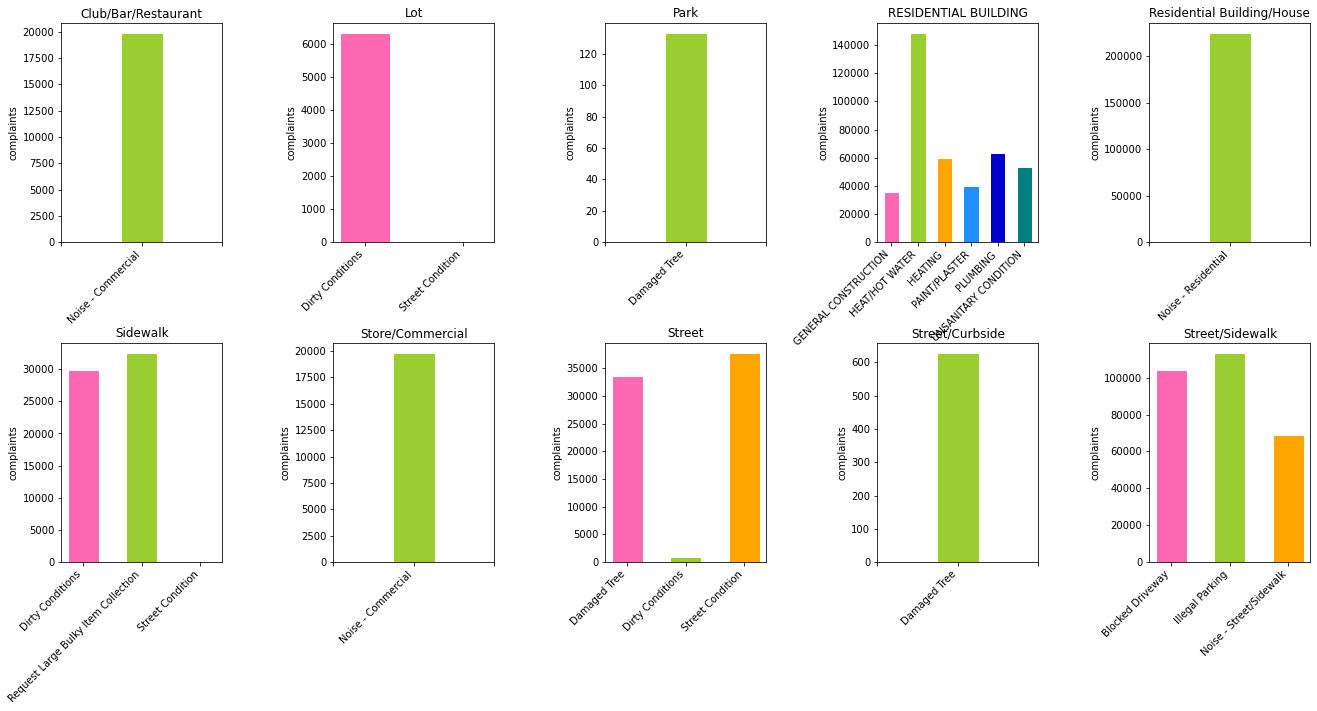

In [36]:
# getting top 20 complaint data
top_20_complaints = service_dataset['Complaint Type'].value_counts().head(20).rename_axis('unique_values').to_frame('counts')
top_20_complaints = top_20_complaints.index.tolist()
top_20_complaints_data = service_dataset[service_dataset['Complaint Type'].isin(top_20_complaints)]

# getting top 20 location types
top_20_locations = service_dataset['Location Type'].value_counts().head(20).rename_axis('unique_values').to_frame('counts')
top_20_locations = top_20_locations.index.tolist()
top_20_locations_data = top_20_complaints_data[top_20_complaints_data['Location Type'].isin(top_20_locations)]


# group the data by Location type
g = top_20_locations_data.groupby('Location Type')

fig, axes = plt.subplots(2, 5, figsize = (20,10))
axes = axes.flatten()

fig.tight_layout(pad=8.0)

colours = ['hotpink','yellowgreen','orange','dodgerblue','mediumblue','teal','orchid','darkorchid','lightpink','olivedrab',
          'royalblue','plum','yellow','tomato','gold','orangered','lightskyblue','lightcoral','palevioletred','green']


#fill each subplot with histogram
for i, (cat, group) in enumerate(g): 
    axes[i].set_title(cat)
    axes[i].set_ylabel('complaints')
    labels, counts = np.unique(group['Complaint Type'], return_counts=True)


    if len(labels) == 1:
        axes[i].set_xlim(0, 2)
        axes[i].set_xticks(range(3))
        labels = ['',labels[0],'']
        counts = [0,counts[0],0]
        axes[i].set_xticklabels(labels, rotation=45, ha='right')
    else:
        axes[i].set_xticks(range(len(labels)))
        axes[i].set_xticklabels(labels, rotation=45, ha='right')
    
    
    barlist= axes[i].bar(labels, counts, align='center',width=0.5)
    
    for j,b in enumerate(barlist):
        barlist[j].set_color(colours[j])

plt.show()

From above we see that on sidewalks and streets, the most common complaints are illegal parking, blocked driveway and noise. Also street conditions and damaged trees seem to be an issue on the streets of New York City. In parks, the most common complaint is damaged trees, while in clubs/bars/restuarants, the most common complaint is noise.

<br>

##### Latitude and Longitude attributes

To get a more visual understanding of the spatial patterns we want to place each complaint on a map and colour code it according to is category. We will use the latitude and longitude attributes for this. To not overcrowd the map, we will just map the complaints from a specific month - let's say march 2020 where many people are inside their homes, and may have more to complain about. We'll also just use the 10 most frequent complaint types instead of the 40, so that all the different coloured dots won't become too confusing:


In [75]:
import folium
map = folium.Map()
map = folium.Map([40.7,-73.9], tiles = "cartodbpositron",zoom_start=11)

# select the top 10 complaints
top_10_complaints = service_dataset['Complaint Type'].value_counts().head(10).rename_axis('unique_values').to_frame('counts')
top_10_complaints = top_10_complaints.index.tolist()
top_10_complaints_data = service_dataset[service_dataset['Complaint Type'].isin(top_10_complaints)]


# choose the data to plot: year 2020, month march
top_10_complaints_2020 = top_10_complaints_data[top_10_complaints_data['Created Date'].dt.year == 2020]
top_10_complaints_2020  = top_10_complaints_2020 [top_10_complaints_2020 ['Created Date'].dt.month == 3]

top_10_complaints_2020 = top_10_complaints_2020[top_10_complaints_2020['Longitude'].apply(lambda x: isinstance(x, float))]
top_10_complaints_2020 = top_10_complaints_2020[top_10_complaints_2020['Latitude'].apply(lambda x: isinstance(x, float))]

colors = ['hotpink','yellowgreen','orange','dodgerblue','mediumblue','teal','orchid','darkorchid','lightpink','olivedrab']

col_map = dict(zip(top_10_complaints, colors))
print(col_map)
for index, row in top_10_complaints_2020.iterrows():
    complaint_type = row['Complaint Type']
    folium.CircleMarker([row.Latitude, row.Longitude], radius= 1, color= col_map[complaint_type]).add_to(map)
    
map

{'Noise - Residential': 'hotpink', 'HEAT/HOT WATER': 'yellowgreen', 'Illegal Parking': 'orange', 'Blocked Driveway': 'dodgerblue', 'Street Condition': 'mediumblue', 'Noise - Street/Sidewalk': 'teal', 'Water System': 'orchid', 'PLUMBING': 'darkorchid', 'HEATING': 'lightpink', 'Street Light Condition': 'olivedrab'}


The map clearly shows some clusters of orange dots (illegal parking) in the south of Brooklyn, clusters of green dots (heat/hot water) in Bronx and areas with pink dots (residential noise) in Brooklyn. Clusters of light blue dots are also present in two areas of Brooklyn representing blocked driveways. Lastly there are many dark blue dots on Staten Island, representing bad street conditions.

<br>

#### Exploring the temporal patterns in the data 

Now that we have a better understanding of the spatial patterns in the data, we want to look at the temporal information. Let's first list the top 10 days where most complaints have been made in the alst ten years:

In [37]:
service_dataset['Created Date'].value_counts().head(10)

2013-01-24    768
2014-01-07    729
2015-01-08    708
2014-01-23    627
2015-02-16    626
2012-01-04    595
2014-01-08    591
2014-01-22    584
2013-11-25    559
2015-01-07    556
Name: Created Date, dtype: int64

From above it is clear that january is a month where many complaints are filed. January is a cold month so perhaps many people are filing complaints if the heating is not working.

In [38]:
service_dataset[service_dataset['Created Date'].dt.month == 1]['Complaint Type'].value_counts().head(10)

HEAT/HOT WATER            29909
Noise - Residential       18454
HEATING                   14093
Blocked Driveway           9861
Illegal Parking            9811
Street Condition           8013
Water System               6609
PLUMBING                   6437
Street Light Condition     4975
UNSANITARY CONDITION       4242
Name: Complaint Type, dtype: int64

From above we can indeed se that heating and hot water are the first and third main complaints in January.

<br>

##### Map out when complaints occur most frequently for each category

Let's now examine how the amount of complaints of each type have changed over the past decade:

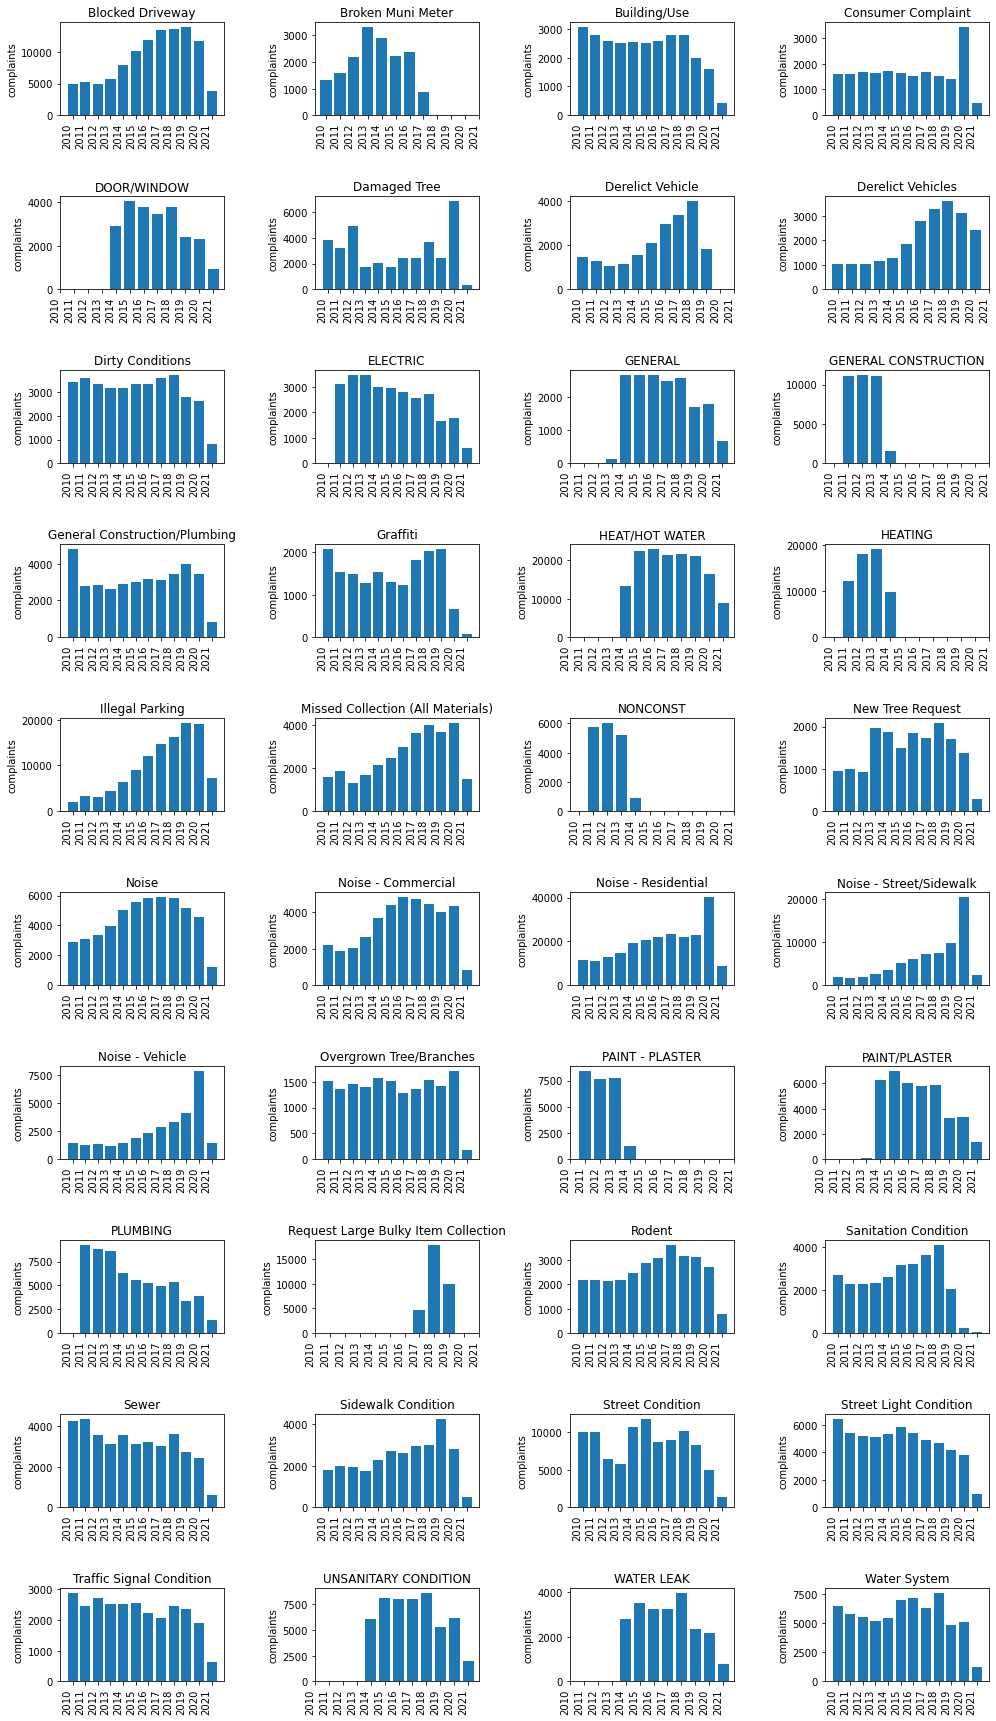

In [39]:
# group the data by complaint type
g = top_40_complaints_data.groupby('Complaint Type')


fig, axes = plt.subplots(10, 4, figsize = (15,25))
axes = axes.flatten()

fig.tight_layout(pad=6.0)

year_labels = ["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020","2021"]
years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]

#fill each subplot with histogram
for i, (cat, group) in enumerate(g): 
    axes[i].set_title(cat)
    axes[i].set_ylabel('complaints')
    labels, counts = np.unique(group["Created Date"].dt.year, return_counts=True)
        
    barlist= axes[i].bar(labels, counts, align='center')

    axes[i].set_xticks(years)
    axes[i].set_xticklabels(year_labels, rotation = 90, ha="right")
    
plt.show()



Some trends that can be noted are:
* Illegal parking, derelict vehicles, blocked driveway and missed collection of materials are all following a steady increase in number of complaints. It could seem like vehicle problems are becoming more common in New York City.
* Street light condition, plumbing, sewer, electric and paint/plaster complaints are all following a steady decline in number of complaints. This indicates a trend towards better residential standards.
* In 2020, which has been a year where many people have been locked up in their homes, has seen a significant increase in the amount of complaints about noise coming from the streets, vehicles and other residents. Moreover, 2020 saw a big increase in the number of consumer complaints and also damaged trees
* In 2019 sidewalk condition complaints were quite high compared to other years
* Rodent complaints peaked in 2017, but have since declined, indicating that the situation is bettering 
* The graffiti category has had an increased number of complaints in the years 2010 and 2017-2019


<br>

It can also be interesting to see if the complaint types being made in New York change throughout the year, meaning how the month plays a role on the type of complaint. We already saw that most of the days with the highest number of complaints were made in January. Could there be some other months where complaints are higher or lower than normal?

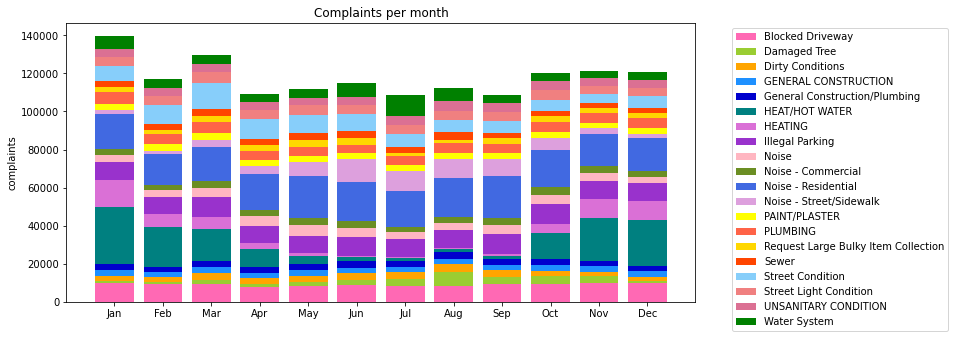

In [46]:
# group the data by complaint type
g = top_20_complaints_data.groupby('Complaint Type')

fig, ax = plt.subplots(figsize = (10,5))


fig.tight_layout(pad=3.0)

ax.set_title('Complaints per month')
ax.set_ylabel("complaints")

colors = ['hotpink','yellowgreen','orange','dodgerblue','mediumblue','teal','orchid','darkorchid','lightpink','olivedrab','royalblue','plum','yellow','tomato'
         ,'gold','orangered','lightskyblue','lightcoral','palevioletred','green']

counts_ =[]
for i, (cat, group) in enumerate(g): 
    labels, counts = np.unique(group["Created Date"].dt.month, return_counts=True)
    
    if i == 0:
        p = ax.bar(labels, counts, align='center', color = colors[i])
        counts_=counts
    else:
        p = ax.bar(labels, counts,bottom=counts_, align='center', color = colors[i])
        counts_=counts_ + counts
    

ax.legend(labels=g.groups.keys(),bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.setp(ax, xticks=[1,2,3,4,5,6,7,8,9,10,11,12], xticklabels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.show()


The graph shows us that heat/hot water complaints are most frequent during the winter months Oct-Mar which is expected. Noise from streets and sidewalks increase during the summer months, since there are more people out in the streets. Some other interesting observations are that water system complaints seem to be peaking in July and that damaged tree complaints are highest in August. Overall we can see that January and March are months where more complaints are submitted, compared to other months, and July and September are the months were fewest complaints are made. In July many people are probably away on holiday so won't be making as many complaints.

We can also examine how different complaints are being made during the 24 hours of the day

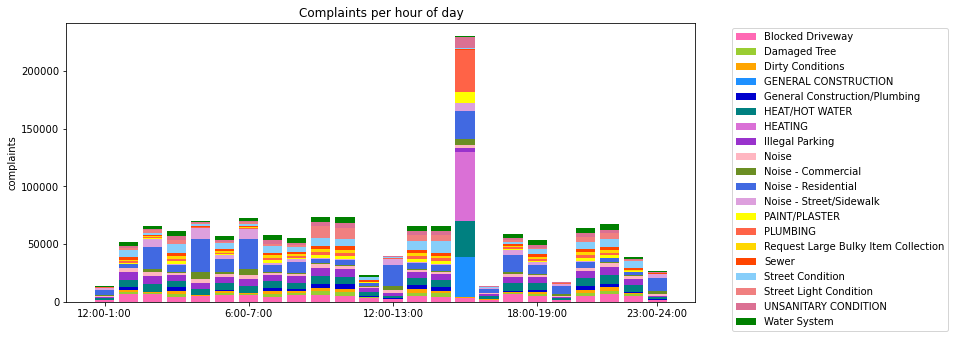

In [78]:
# group the data by complaint type
g = top_20_complaints_data.groupby('Complaint Type')


fig, ax = plt.subplots(figsize = (10,5))

fig.tight_layout(pad=3.0)

ax.set_title('Complaints per hour of day')
ax.set_ylabel("complaints")

colors = ['hotpink','yellowgreen','orange','dodgerblue','mediumblue','teal','orchid','darkorchid','lightpink','olivedrab','royalblue','plum','yellow','tomato'
         ,'gold','orangered','lightskyblue','lightcoral','palevioletred','green']

labels_list = top_20_complaints_data["Created Date"].dt.hour.unique()
counts_ = []
for i, (cat, group) in enumerate(g): 
    counts_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    labels, counts = np.unique(group["Created Date"].dt.hour, return_counts=True)
    for j,c in enumerate(counts):
        ind = labels[j]
        counts_list[ind] = c
        
    if i == 0:
        p = ax.bar(labels_list, counts_list, align='center', color = colors[i])
        counts_=counts
    else:
        p = ax.bar(labels_list, counts_list,bottom=counts_, align='center', color = colors[i])
        counts_=counts_ + counts_list
    
    
ax.legend(labels=g.groups.keys(),bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.setp(ax, xticks=[0,6,12,18,23], xticklabels=["12:00-1:00","6:00-7:00","12:00-13:00","18:00-19:00","23:00-24:00"])
plt.show()

We can see that the majority of complaints are made in the time interval 15:00-16:00. However, since the amount of complaints in this interval is more than double that of the rest of the time intervals, it is likely that it could just be a placeholder that is used when it is unclear when a complaint was made. Apart from that, there are few complaints made from 11:00-12:00, 16:00-17:00 and 19:00-20:00. Especially at 19 o'clock people tend to eat dinner, which could explain the low amount of complaints. There are quite a lot of complaints during the hours of the night as well. Especially the type residential noise is prevalent during the night.

<br>

##### Duration attribute

We also want to examine the duration of different kinds of complaints to find out if some take longer to resolve than others. First let's find the complaints that have had the longest duration overall:


In [62]:
# what are the complaints with the longest durations?
sorted_duration_data = service_dataset.sort_values(by=['Duration'])
sorted_duration_data[sorted_duration_data['Duration'].notnull()][['Complaint Type','Descriptor','Created Date','Closed Date','Duration']].tail(10)


Complaint Type  \
63973    General Construction/Plumbing   
1345204                          Sewer   
367256   General Construction/Plumbing   
441850            Forensic Engineering   
827017                   Stalled Sites   
2117767                   Building/Use   
1419689  General Construction/Plumbing   
844011            Forensic Engineering   
938817   General Construction/Plumbing   
704494             Cranes and Derricks   

                                                Descriptor  \
63973                               Building Permit - None   
1345204                Manhole Sunken/Damaged/Raised (SB1)   
367256   Egress - Doors Locked/Blocked/Improper/No Seco...   
441850                   Second Avenue Subway Construction   
827017                           Stalled Construction Site   
2117767   Illegal Conversion Of Residential Building/Space   
1419689                                Failure To Maintain   
844011                   Second Avenue Subway Construction   
938817                              Building Permit - None   
704494   Crane/Suspension Scaffold - No Permit/License/...   

               Created Date         Closed Date           Duration  
63973   2011-01-13 14:23:55 2020-09-21 00:00:00 3538 days 09:36:05  
1345204 2010-05-11 11:08:00 2020-02-20 03:30:00 3571 days 16:22:00  
367256  2010-12-13 11:15:20 2020-10-20 00:00:00 3598 days 12:44:40  
441850  2010-10-15 16:20:11 2020-08-27 00:00:00 3603 days 07:39:49  
827017  2010-07-28 10:07:59 2020-07-10 00:00:00 3634 days 13:52:01  
2117767 2010-10-26 12:08:51 2020-11-19 00:00:00 3676 days 11:51:09  
1419689 2010-05-18 12:16:16 2020-07-02 00:00:00 3697 days 11:43:44  
844011  2010-06-24 06:29:28 2020-08-27 00:00:00 3716 days 17:30:32  
938817  2010-11-09 15:31:12 2021-03-09 00:00:00 3772 days 08:28:48  
704494  2010-03-08 10:31:17 2020-12-02 00:00:00 3921 days 13:28:43

The complaint that has taken the longest to be resolved is one regarding a crane or scaffold that has been set up without a permit. It took ca. 10 years before it was resolved. The rest of the complaints with the longest durations also have to do with construction. There are also cases of forensic engineering connected to the construction of the subway on second avenue, which have been going on for ten years as well. These perhaps have to do with a potential breach of the law during construction.

<br>

Let's also calculate the average duration for each complaint type, to get an idea of the duration for each type of complaint:

In [68]:
# keep the positive and not null durations
duration_data = service_dataset[service_dataset["Duration"].notnull()]
duration_data = duration_data[duration_data["Duration"].dt.days>=0]

# let's just look at the top 20 complaints
duration_data = duration_data[duration_data['Complaint Type'].isin(top_20_complaints)]


In [69]:
# group the data by complaint type
g = duration_data.groupby('Complaint Type')

for (cat,group) in g:
    avg_duration = group['Duration'].dt.days.mean()
    print('Complaint type: ', cat, 'Average duration: ',avg_duration )

Complaint type:  Blocked Driveway Average duration:  0.1294900428066257
Complaint type:  Damaged Tree Average duration:  47.53908839779005
Complaint type:  Dirty Conditions Average duration:  4.825454545454545
Complaint type:  GENERAL CONSTRUCTION Average duration:  13.823320690077082
Complaint type:  General Construction/Plumbing Average duration:  60.24268111035884
Complaint type:  HEAT/HOT WATER Average duration:  2.76358242040455
Complaint type:  HEATING Average duration:  4.2496050552922595
Complaint type:  Illegal Parking Average duration:  0.08258232532638865
Complaint type:  Noise Average duration:  4.994850294815836
Complaint type:  Noise - Commercial Average duration:  0.059459730115414465
Complaint type:  Noise - Residential Average duration:  0.10113257304528546
Complaint type:  Noise - Street/Sidewalk Average duration:  0.10970319634703196
Complaint type:  PAINT/PLASTER Average duration:  17.85576624987083
Complaint type:  PLUMBING Average duration:  16.38436369044668
Comp

Noise complaints and parking complaints (including blocked driveways) are the fastest to be resolved, and only take less than a day on average. Complaints that take a long time to be resolved include general construction (60 days), damaged trees (47) and unsanitary conditions (22). Complaints that take around 2 weeks on average are: PAINT/PLASTER, PLUMBING, Sewer and Street Light Condition. 

These results make sense, since noise complaints and parking can normally be solved on the same day, whereas maintenance issues such as plumbing or painting can take some more time before a worker has time to help. However it was surprising that unsanitary conditions on average take 22 days before they are resolved, since that is quite a long time to wait for especially if it is a residential building that is unsanitary.

<br>

#### Exploring how different complaints have been filed

Complaints can be filed in different ways including by phone, online or by mobile phone. We have some assumptions about how complaint type and time of day influence the method of filing a complaint. First of all it seems that most complaints that are aimed at things outside of the home would be filed by mobile phone and that complaints from the home would be submitted using the phone. Secondly, the complaints that happen while people are out during the day would also be submitted with a mobile phone, while in the hours where people are home after or before work would tend to be submitted more frequently by phone or online. Let's examine if these hypotheses are true.

In [60]:
service_dataset['Open Data Channel Type'].value_counts()

PHONE      1151211
ONLINE      444734
UNKNOWN     400358
MOBILE      204988
OTHER        35802
Name: Open Data Channel Type, dtype: int64

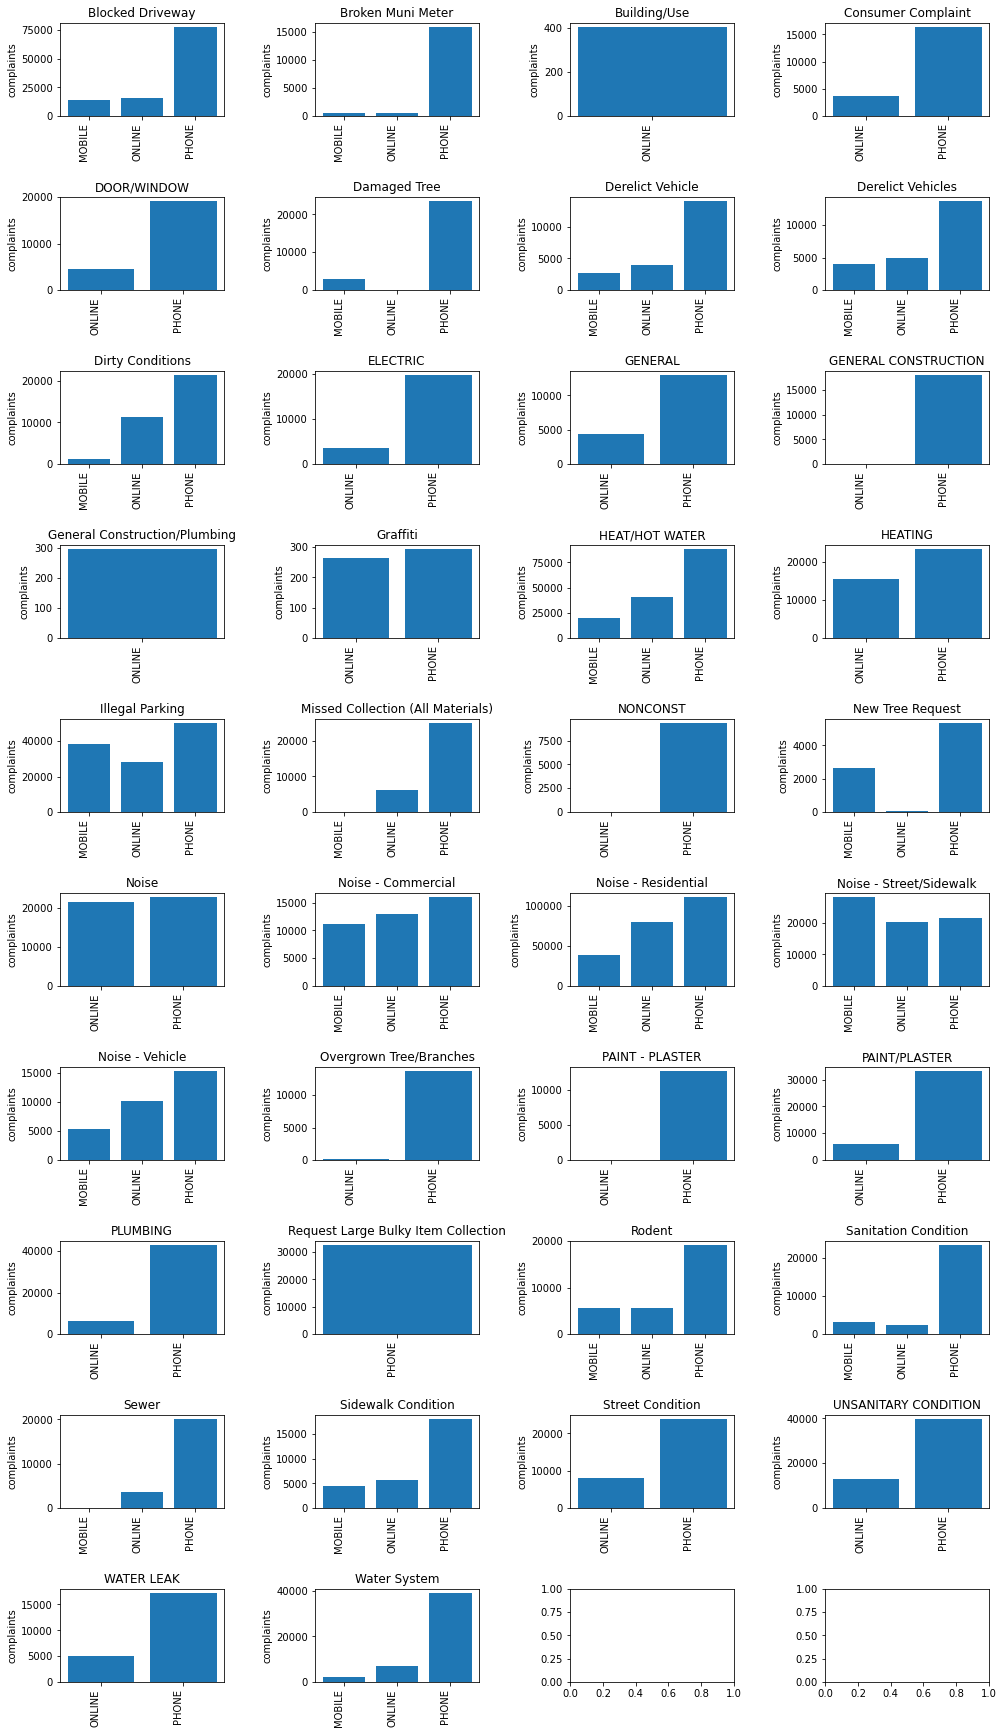

In [71]:
# only select the ones that aren't unknown or other
complaint_method_data = top_40_complaints_data[top_40_complaints_data['Open Data Channel Type'].isin(['PHONE','ONLINE','MOBILE'])]

# group the data by complaint type
g = complaint_method_data.groupby('Complaint Type')


fig, axes = plt.subplots(10, 4, figsize = (15,25))
axes = axes.flatten()

fig.tight_layout(pad=6.0)

year_labels = ["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020","2021"]
years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]

#fill each subplot with histogram
for i, (cat, group) in enumerate(g): 
    axes[i].set_title(cat)
    axes[i].set_ylabel('complaints')
    labels, counts = np.unique(group['Open Data Channel Type'], return_counts=True)
        
    barlist= axes[i].bar(labels, counts, align='center')

    axes[i].set_xticks(range(len(labels)))
    axes[i].set_xticklabels(labels, rotation = 90, ha="right")
    
plt.show()

Our hypothesis does not seem to be correct, since almost all types of complaints are mostly submitted by phone. One exception, however, is noise from the street or sidewalk which is most frequently being submitted via mobile phone, which partly confirms our hypothesis. General noise and grafiti are also almost as frequently being submitted via mobile phone as via phone. Building/Use and General Construction/Plumbing are almost exclusively being submitted online. It looks like these could be some labels that are being used by a specific agency, which happens to submit these complaints directly.

<br>

Now moving on to the influence of the time of day on the way complaints are made:

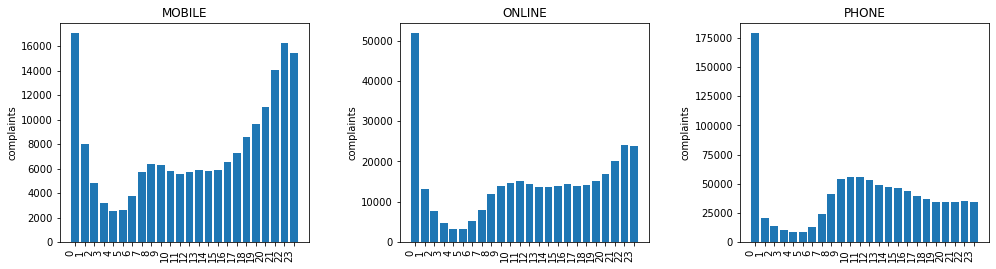

In [85]:
channel_data =  top_40_complaints_data[top_40_complaints_data['Open Data Channel Type'].isin(['PHONE','ONLINE','MOBILE'])]

# group the data by complaint typ
g = channel_data .groupby('Open Data Channel Type')

fig, axes = plt.subplots(1, 3, figsize = (15,5))
axes = axes.flatten()

fig.tight_layout(pad=6.0)

year_labels = ["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020","2021"]
years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]

#fill each subplot with histogram
for i, (cat, group) in enumerate(g): 
    axes[i].set_title(cat)
    axes[i].set_ylabel('complaints')
    labels, counts = np.unique(group['Created Date'].dt.hour, return_counts=True)
        
    barlist= axes[i].bar(labels, counts, align='center')

    axes[i].set_xticks(range(len(labels)))
    axes[i].set_xticklabels(labels, rotation = 90, ha="right")
    
plt.show()

For each of the three categories, the temporal patterns seem quite similar, except that mobile and online methods have an upwards slope towards the hours of the evening, whereas the use of phone is declining. Noteworthy is also the peak at 0 o'clock, which is most likely the hour assigned to complaints where the exact time is unknown.

<br>

#### Summary of what we have learned in the exploratory data analysis phase

From our initial analysis we discovered that:
* Residential noise is the top complaint in New York City
* Most complaints are towards issues in residential buildings
* Queens is the borough that complains the least and Bronx the most(relative to their populations)
* There is a clear distinction in the types of complaints that are most common in different boroughs
* Noise complaints increased a lot during 2020
* Complaints related to parking and vehicles have seen a steady increase over the past decade
* Sidewalk/street noise peaks in the summer months, while heating complaints peak in winter months
* January sees the most complaints being made 
* Construction type requests took the longest to be resolved while noise and parking issues were resolved the quickest
* People generaly submit complaints by phone, but at night the submission by mobile phone and online methods increases

# Data Analysis

One of the main things we want to explore is how the corona crisis has affected complaints made in New York City. Which types of complaints have increased and which have decreased. Have people in general made more or less complaints and has the time of day where complaints are made, changed?

Secondly we are also interested in using machine learning - more precisely a random forest classifier - to find out if we can predict a complaint category from some of the other attributes in the service request dataset.

### Analysis: How has the Covid-19 pandemic affected complaints in New York City

Have people in general submitted more complaints under the pandemic compared to previous years?

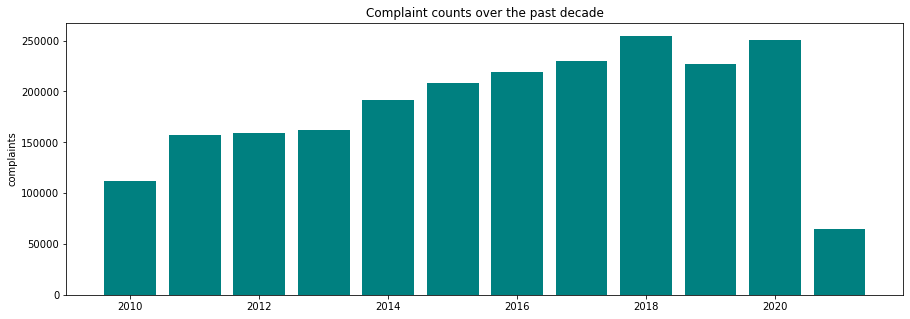

In [101]:
# group the data by complaint type
g = service_dataset.groupby(service_dataset['Created Date'].dt.year)


fig, ax = plt.subplots(1, figsize = (15,5))

counts = [len(group['Complaint Type']) for (cat, group) in g]

ax.set_title('Complaint counts over the past decade')
ax.set_ylabel('complaints')
ax.bar(years, counts, align='center', color='teal')

    
plt.show()

Complaints have seen a steady increase over the past decade, and it seems that the year 2020 has not changed this trend. The number of complaints in 2020 have been quite similar to the year 2018, so people are neither making more or less complaints than the usual.

What have been the top complaints during the year 2020, compared to all previous years?

In [91]:
service_dataset_2020 = service_dataset[service_dataset['Created Date'].dt.year == 2020]
service_dataset_2020['Complaint Type'].value_counts().head(10)

Noise - Residential                    40379
Noise - Street/Sidewalk                20572
Illegal Parking                        19009
HEAT/HOT WATER                         16323
Blocked Driveway                       11682
Non-Emergency Police Matter             8369
Noise - Vehicle                         7919
Damaged Tree                            6886
UNSANITARY CONDITION                    6158
NonCompliance with Phased Reopening     5093
Name: Complaint Type, dtype: int64

In [92]:
service_dataset_not2020 = service_dataset[service_dataset['Created Date'].dt.year != 2020]
service_dataset_not2020['Complaint Type'].value_counts().head(10)

Noise - Residential        188860
HEAT/HOT WATER             131828
Illegal Parking             97774
Blocked Driveway            95811
Street Condition            92436
Water System                62734
HEATING                     59257
PLUMBING                    58874
Street Light Condition      53503
Noise - Street/Sidewalk     49562
Name: Complaint Type, dtype: int64

Some interesting observations can be seen here:
* Residential noise is still in the top, which is expected since a lot of 2020 was spent in lockdown. 
* Noise from the street and sidewalk has overtaken second place which had prior belonged to heat and hot water problems. This is surprising since we would expect that there would be less people and traffic on the streets due to the lockdown. However this increase could be described by the fact that people don't normally complain about noise from the streets if they are not at home, and so the increase is due to people being home (likely working from home) and these noises therefore being reported more.
* There's a big increase in non-emergency police matter complaints, which was not even on the top 10 before 2020.
* On tenth place is non-compliance with phased reopening, which is related to the corona pandemic.

We would like to examine the descriptor field of the two categories 'Non-Emergency Police Matter' and 'NonCompliance with Phased Reopening' to see more precisely what these complaints are aimed towards:

In [93]:
non_emergency_data = service_dataset_2020[service_dataset_2020['Complaint Type'] == 'Non-Emergency Police Matter']
non_emergency_data['Descriptor'].value_counts().head(10)

Social Distancing            5956
Face Covering Violation      1159
Other (complaint details)     876
Trespassing                   376
Street Con Game                 2
Name: Descriptor, dtype: int64

In [94]:
phased_reopening_data = service_dataset_2020[service_dataset_2020['Complaint Type'] == 'NonCompliance with Phased Reopening']
phased_reopening_data['Descriptor'].value_counts().head(10)

Business not in compliance          4288
Business not allowed to be open      442
Restaurant/Bar Not in Compliance     363
Name: Descriptor, dtype: int64

Not surprisingly, there has been a lot of complaints related to social distancing and the violation of face coverings. It would be interesting to see the spatial patterns in such complaint types, to get an idea of which areas are more lenient with the corona guidelines. We can also see that there have been quite a lot of complaints towards businesses not complying with the orders to keep closed. We also want to explore the spatial pattern in this category of complaints.

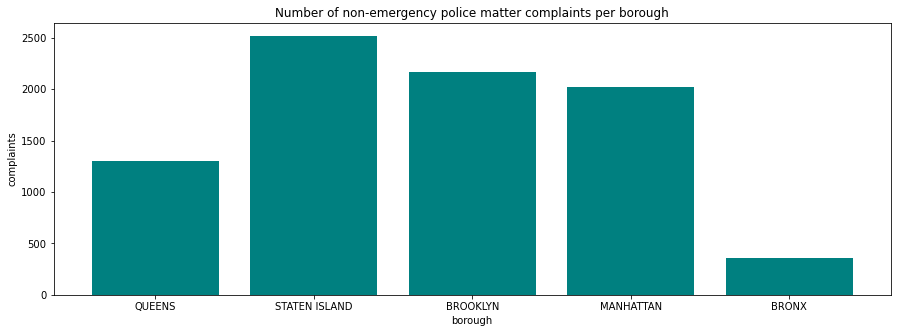

In [125]:
# group the data by borough 
g = non_emergency_data.groupby(service_dataset['Borough'])

fig, ax = plt.subplots(1, figsize = (15,5))

ax.set_title('Number of non-emergency police matter complaints per borough')
ax.set_ylabel('complaints')
ax.set_xlabel('borough')

labels_list = non_emergency_data['Borough'].unique().tolist()
counts = [len(group['Complaint Type']) for (cat, group) in g]

ax.bar(labels_list, counts, align='center', color='teal')

    
plt.show()

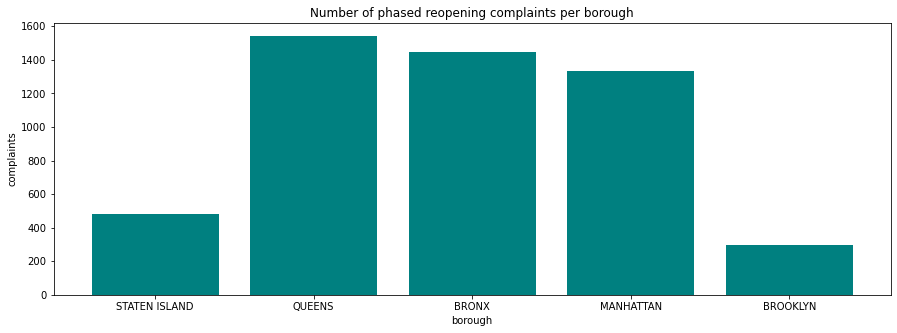

In [126]:
# group the data by borough 
g = phased_reopening_data.groupby(service_dataset['Borough'])

fig, ax = plt.subplots(1, figsize = (15,5))

ax.set_title('Number of phased reopening complaints per borough')
ax.set_ylabel('complaints')
ax.set_xlabel('borough')

labels_list = phased_reopening_data['Borough'].unique().tolist()
counts = [len(group['Complaint Type']) for (cat, group) in g]

ax.bar(labels_list, counts, align='center', color='teal')

plt.show()

Staten Island seems to have the most problems with people not following corona guidelines, while Queens is the borough where most businesses are opening, even if they are not allowed.

<br>

Lastly, it is also interesting to see how the different types of complaints unfolded throughout the year and compare them to the graph we made earlier, which included all years:

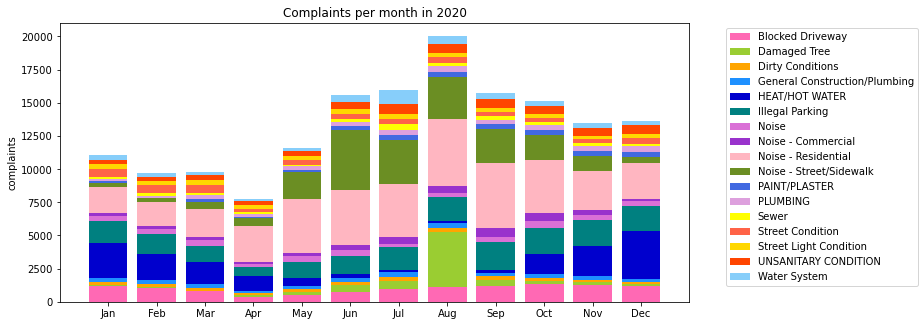

In [129]:
# group the data by complaint type
top_20_complaints_data_2020 = top_20_complaints_data[top_20_complaints_data['Created Date'].dt.year == 2020]
g = top_20_complaints_data_2020.groupby('Complaint Type')

fig, ax = plt.subplots(figsize = (10,5))

fig.tight_layout(pad=3.0)

ax.set_title('Complaints per month in 2020')
ax.set_ylabel("complaints")

colors = ['hotpink','yellowgreen','orange','dodgerblue','mediumblue','teal','orchid','darkorchid','lightpink','olivedrab','royalblue','plum','yellow','tomato'
         ,'gold','orangered','lightskyblue','lightcoral','palevioletred','green']

counts_ =[]
for i, (cat, group) in enumerate(g): 
    labels, counts = np.unique(group["Created Date"].dt.month, return_counts=True)
    
    if i == 0:
        p = ax.bar(labels, counts, align='center', color = colors[i])
        counts_=counts
    else:
        p = ax.bar(labels, counts, bottom=counts_, align='center', color = colors[i])
        counts_=counts_ + counts
    

ax.legend(labels=g.groups.keys(),bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.setp(ax, xticks=[1,2,3,4,5,6,7,8,9,10,11,12], xticklabels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.show()


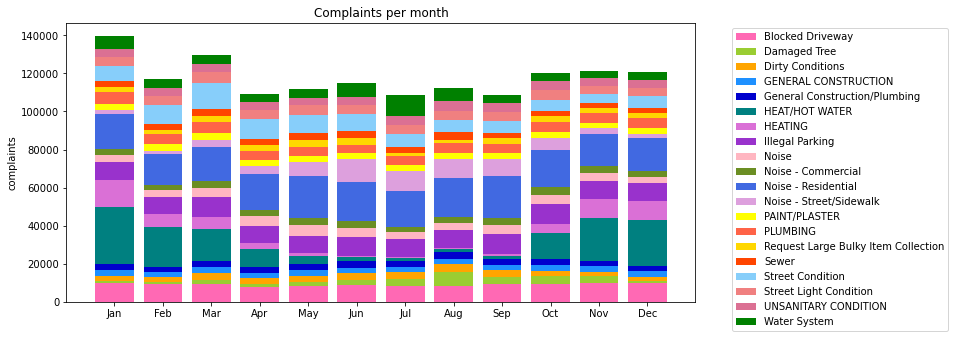

In [128]:
# group the data by complaint type
g = top_20_complaints_data.groupby('Complaint Type')

fig, ax = plt.subplots(figsize = (10,5))


fig.tight_layout(pad=3.0)

ax.set_title('Complaints per month')
ax.set_ylabel("complaints")

colors = ['hotpink','yellowgreen','orange','dodgerblue','mediumblue','teal','orchid','darkorchid','lightpink','olivedrab','royalblue','plum','yellow','tomato'
         ,'gold','orangered','lightskyblue','lightcoral','palevioletred','green']

counts_ =[]
for i, (cat, group) in enumerate(g): 
    labels, counts = np.unique(group["Created Date"].dt.month, return_counts=True)
    
    if i == 0:
        p = ax.bar(labels, counts, align='center', color = colors[i])
        counts_=counts
    else:
        p = ax.bar(labels, counts,bottom=counts_, align='center', color = colors[i])
        counts_=counts_ + counts
    

ax.legend(labels=g.groups.keys(),bbox_to_anchor=(1.05, 1), loc='upper left',)
plt.setp(ax, xticks=[1,2,3,4,5,6,7,8,9,10,11,12], xticklabels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.show()


We can see that August was the month where most complaints were made in 2020. Many of these complaints were however for damaged trees which are likely due to the storm Isaias that happened in New York in August 2020. 2020 also has a larger proportion of noise from streets and sidewalks compared to previous years, especially during the summer months. A complaint that seems to have decrease under corona compared to previous years is street condition complaints. With more people staying inside their homes, not commuting to work and virtually no tourists allowed into New York, this trend seems very logical.

### Can we use machine learning to predict complaint type from spatial and temporal data?

We want to train a random forest classifier to be able to predict the top 20 complaint types, using a subset of the attributes in our dataset.

# Genre. Which genre of data story did you use?

Screenshots of our webpage are shown below:

![image](graph1.png)
![image](graph2.png)
![image](graph3.png)
![image](graph4.png)
![image](graph5.png)
![image](graph6.png)

Our website mainly follows the partitioned poster genre, with the addition of annotated graphs, and the last section also resembling the magazine style. The first part of our website (with the pink background) doesn't have a specific structure to it. The user can choose to explore the data by filtering the complaint type or the year on their own and then also look at how the two graphs below change accordinlgy. The whole first part is meant to be user-driven rather than author-driven, to let the user get a feel of the data themselves, before the second part of the webpage. The user-driven part is important since this dataset can really be explored in many ways and allowing the user to do their own findings, means that the user will hopefullly learn more than if they are pasively reading somebody elses findings.

The second part of the webpage (white background) however is more author-driven and takes the user through some graphs that show some patterns during the corona pandemic. This part follows more of a magazine style, where there is text and accompanying plots which aren't interactive. This type of genre is also important, since it can help tell more of a story to the user, and guide any users which may not find anyting interesting by looking at the data by themselves.

We also used the tools mentioned in the Segel and Heer paper. 

Visual Narrative tools we used:
* Consisten visual platform -  in the second part of the website, two colmns are consistently kept, so that the viewer is prepared that some comparisons are going to be happening going further down the page.
* Feature distinction -  on the plots where more than one type of complaint are present the complaints will be color coded so that it is easier to distinguish between them.
* Familiar objects - bar charts are used a lot throughout the website, so that users don't have to wrap their head around a lot of different types of plots. 

Narrative Structure tools we used:
* In the ordering category, the webpage is using a bit of everything, the start is very user directed whereas the second part is very linear.
* Hover highligting/details were used in the map, where users can see details on demand when hovering over the point. Such information includes when the complaint was made and a more precise description of the complaint.
* Filtering/selection/search is also used in the graph.
* In the second part of the webpage, an accompanying article or comments are given together with the plots, to guide the user through the analysis.
* The webpage also uses an introductory text, which introduces the dataset to the viewer.


# Visualizations

As mentioned above, interaction with the plots was a priority, so the first visualisation on the webpage is an interactive map pf New York City where each complaint has been marked with a little dot. Having this as the first thing enables the viewer to get into the structure of the data and its atttributes, and get some curiosity for the data. Each dot is colour coded according to its complaint type, and by hovering over it, additonal information about that datapoint will be shown. The interactivity is increased by adding both a slider to select a specific year and also a dropdown box where a complaint type can be selected. Two more bar graphs are displayed under the map, which also show the same filtered data as on the map (these two graphs are also updated when a year or category has been selected). The first graph displays the spatial information more in depth by breaking down the selected data into boroughs. The second bar graph displays the temporal information by breaking down the number of complaints for each hour of the day.

This first part of the website thus follows the overview first, search/filter and then details on demand structure.

The second part of the website contains static graphs except for the last two ones. Stacked bar graphs were used in the webpage so that we could display how different complaint types behave in different months of the year in a single graph without having to make multiple plots for each complaint categories. The graphs in this second part were all chosen to be bar charts since we wanted the graphs to be part of the narration, and if we changed up the graphs all the time, the natural flow of the story would be broken up a bit while the user would have to understand how the new graph worked.



# Discussion. Think critically about your creation

Unfortunately we ran out of time, so we did not manage to implement the random forest classifier as we would have liked to do. We chose to prioritise more data analysis, since it gives us more concrete results than we could have gotten with a complaint type classifier. Of couse it would have been very interesting if we were able to predict the complaint type based on a location and time, however we would not be able to use this for our website.

Additionally, we could have gone more in depth with the analysis of the trends throughout 2020 on the webpage, since they are quite brief right now.


# References

Data is taken from: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9 <br>
Dash and Plotly was used to create the webpage: https://dash.plotly.com <br>
Segel and Heer paper: http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf

# Contributors

Christina Nørgaard Bartozzi (s205745)